# Справочник

## Токенизатор

Токенизатор реализован на регулярных выражениях. Для каждого типа токенов есть своё правило со своей регуляркой:

In [1]:
from yargy.tokenizer import DEFAULT_RULES


DEFAULT_RULES

[RussianRule('[а-яё][а-яё\\-]*', set()),
 LatinRule("[a-z]\\-?[a-z\\']*", {'LATN'}),
 IntRule('\\d+', {'INT', 'NUMBER'}),
 QuoteRule('["\\\'«»„“ʼʻ”]', set()),
 PunctuationRule('[-\\\\/!#$%&()\\[\\]\\*\\+,\\.:;<=>?@^_`{|}~№…]', {'PUNCT'}),
 EOLRule('[\n\r]+', {'END-OF-LINE'}),
 OtherRule('\\S', {'OTHER'})]

Токенизатор инициализируется списком правил. По-умолчанию — это `DEFAULT_RULES`:

In [2]:
from yargy.tokenizer import Tokenizer


text = 'a@mail.ru'
tokenizer = Tokenizer()
list(tokenizer(text))

[Token('a', (0, 1), [Form('a', {'LATN'})]),
 Token('@', (1, 2), [Form('@', {'PUNCT'})]),
 Token('mail', (2, 6), [Form('mail', {'LATN'})]),
 Token('.', (6, 7), [Form('.', {'PUNCT'})]),
 Token('ru', (7, 9), [Form('ru', {'LATN'})])]

Пользователь может убрать часть правил из списка или добавить новых:

In [3]:
from yargy.tokenizer import LatinRule


tokenizer = Tokenizer([LatinRule()])
list(tokenizer(text))

[Token('a', (0, 1), [Form('a', {'LATN'})]),
 Token('mail', (2, 6), [Form('mail', {'LATN'})]),
 Token('ru', (7, 9), [Form('ru', {'LATN'})])]

Например, в Yargy есть примитивные правила для токенизации емейлов и телефонов. По-умолчанию они не используются:

In [4]:
from yargy.tokenizer import EmailRule, PhoneRule


text = 'email: ab@mail.ru call: 8 915 132 54 76'
tokenizer = Tokenizer(
    [EmailRule(), PhoneRule()]
    + DEFAULT_RULES
)
list(tokenizer(text))

[Token('email', (0, 5), [Form('email', {'LATN'})]),
 Token(':', (5, 6), [Form(':', {'PUNCT'})]),
 Token('ab@mail.ru', (7, 17), [Form('ab@mail.ru', {'EMAIL'})]),
 Token('call', (18, 22), [Form('call', {'LATN'})]),
 Token(':', (22, 23), [Form(':', {'PUNCT'})]),
 Token(' 8 915 132 54 76', (23, 39), [Form(' 8 915 132 54 76', {'PHONE'})])]

Можно даже запрограммировать своё правило. Например, так выглядит простое правило для извлечения доменов:

In [5]:
from yargy.tokenizer import TokenRule


class DomainRule(TokenRule):
    pattern = '[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+'
    grammemes = {'DOMAIN'}
    
    def normalize(self, value):
        value = value.lower()
        if value.startswith('www.'):
            value = value[4:]
        return value
    
    
text = 'www.VKontakte.ru'
tokenizer = Tokenizer(
    [DomainRule()]
    + DEFAULT_RULES
)
list(tokenizer(text))

[Token('www.VKontakte.ru', (0, 16), [Form('vkontakte.ru', {'DOMAIN'})])]

## Газеттир

В Yargy реализовано два типа газеттиров: `MorphPipeline` и `CaselessPipeline`. `MorphPipeline` перед работой приводит слова к нормальной форме:

In [6]:
from yargy.pipelines import MorphPipeline


class Pipeline(MorphPipeline):
    grammemes = {'Type'}
    
    keys = [
        'электронный дневник',
    ]
    

tokenizer = Tokenizer()
pipeline = Pipeline()
text = 'электронным дневником, электронные дневники, электронное дневнику'
list(pipeline(tokenizer(text)))

[Multitoken('электронным дневником',
            (0, 21),
            [Form('электронный дневник', {'Type'})]),
 Token(',', (21, 22), [Form(',', {'PUNCT'})]),
 Multitoken('электронные дневники',
            (23, 43),
            [Form('электронный дневник', {'Type'})]),
 Token(',', (43, 44), [Form(',', {'PUNCT'})]),
 Multitoken('электронное дневнику',
            (45, 65),
            [Form('электронный дневник', {'Type'})])]

Нужно быть аккуратным с пробелами в `keys`. Слова должны быть разделены так же, как это бы сделал токенизатор. Например, чтобы обработать "dvd-диск", в `keys` должно быть написано `dvd - диск`. Стандартный токенизатор Yargy разбивает "dvd-диск" на три токена.

`CaselessPipeline` используется, когда слова не нужно приводить к нормальной форме. Например, есть арабские имена: "Абд Аль-Азиз Бин Мухаммад", "Абд ар-Рахман Наср ас-Са ди". Их нужно обработать как есть: 

In [7]:
from yargy.pipelines import CaselessPipeline


class Pipeline(CaselessPipeline):
    grammemes = {'Name'}
    keys = [
        'Абд Аль-Азиз Бин Мухаммад',
        'Абд ар-Рахман Наср ас-Са ди',
    ]
    
tokenizer = Tokenizer()
pipeline = Pipeline()
text = 'Абд Аль-Азиз Бин Мухаммад, АБД АР-РАХМАН НАСР АС-СА ДИ'
list(pipeline(tokenizer(text)))

[Multitoken('Абд Аль-Азиз Бин Мухаммад',
            (0, 25),
            [Form('Абд Аль-Азиз Бин Мухаммад', {'Name'})]),
 Token(',', (25, 26), [Form(',', {'PUNCT'})]),
 Multitoken('АБД АР-РАХМАН НАСР АС-СА ДИ',
            (27, 54),
            [Form('Абд ар-Рахман Наср ас-Са ди', {'Name'})])]

## Предикаты

## Интерпретация

Схема объекта, который получается в результате интерпретации описывается конструктором `fact`. Чтобы задать значение поля по-умолчанию, используется метод `attribute`. Например, в `Date` по-умолчанию год будет равен 2017:

In [8]:
from IPython.display import display
from yargy import Parser, rule, fact, attribute, and_, or_
from yargy.predicates import dictionary, gte, lte


Date = fact(
    'Date',
    [attribute('year', 2017), 'month', 'day']
)


MONTHS = {
    'январь',
    'февраль',
    'март',
    'апрель',
    'мая',
    'июнь',
    'июль',
    'август',
    'сентябрь',
    'октябрь',
    'ноябрь',
    'декабрь'
}


MONTH_NAME = dictionary(MONTHS)
DAY = and_(
    gte(1),
    lte(31)
)
YEAR = and_(
    gte(1900),
    lte(2100)
)
DATE = rule(
    DAY.interpretation(
        Date.day
    ),
    MONTH_NAME.interpretation(
        Date.month
    ),
    YEAR.interpretation(
        Date.year
    ).optional()
).interpretation(
    Date
)


text = '''18 июля 2016
15 марта
'''
parser = Parser(DATE)
for line in text.splitlines():
    match = next(parser.match(line))
    display(match.fact)

Date(year=2016,
     month='июля',
     day=18)

Date(year=2017,
     month='марта',
     day=15)

Для дат деревья разбора выглядят просто: вершина-конструктор и несколько детей-атрибутов:

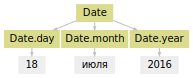

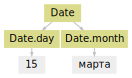

In [9]:
parser = Parser(DATE)
for line in text.splitlines():
    match = next(parser.match(line))
    display(match.tree.normalized.as_dot)

Как будет себя вести алгоритм интерпретации, когда ребёнок конструктора не атрибут, а другой конструктор? Или когда ребёнок атрибута другой атрибут? Или когда под конструктором или атрибутом не одна, а несколько вершин с токенами? Пойдём от простого к сложному. Когда под вершиной-атрибутом несколько токенов, они объединяются:

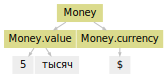

In [10]:
from yargy.predicates import eq, gram, dictionary


Money = fact(
    'Money',
    ['value', 'currency']
)
MONEY = rule(
    rule(
        gram('INT'),
        dictionary({
            'тысяча',
            'миллион'
        })
    ).interpretation(
        Money.value
    ),
    eq('$').interpretation(
        Money.currency
    )
).interpretation(
    Money
)

parser = Parser(MONEY)
match = next(parser.match('5 тысяч$'))
match.tree.as_dot

В `Money.value` будет два слова:

In [11]:
match.fact

Money(value='5 тысяч',
      currency='$')

Получить доступ к исходным токенам можно через атрибут `raw`:

In [12]:
match.fact.raw.value

Chain([NormalizedToken(RawNormalizer(),
                       Token(5, (0, 1), [Form(5, {'INT', 'NUMBER'})])),
       NormalizedToken(RawNormalizer(),
                       Token('тысяч',
                             (2, 7),
                             [Form('тысяча',
                                   {'NOUN',
                                    'femn',
                                    'gent',
                                    'inan',
                                    'plur'})]))])

Когда под вершиной-атрибутом смесь из токенов и вершин-конструктов, они объединяются в список, а не строку:

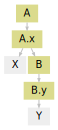

In [13]:
from yargy.predicates import true


A = fact(
    'A',
    ['x']
)
B = fact(
    'B',
    ['y']
)
RULE = rule(
    true(),
    true().interpretation(
        B.y
    ).interpretation(
        B
    )
).interpretation(
    A.x
).interpretation(
    A
)

parser = Parser(RULE)
match = next(parser.match('X Y'))
match.tree.as_dot

В `A.x` будет список из строки и объекта `B`:

In [14]:
match.fact

A(x=['X', B(y='Y')])

Если под вершиной-атрибутом другая вершина-атрибут, нижняя просто исчезает:

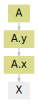

In [15]:
from yargy.predicates import true


A = fact(
    'A',
    ['x', 'y']
)
RULE = true().interpretation(
    A.x
).interpretation(
    A.y
).interpretation(A)

parser = Parser(RULE)
match = next(parser.match('X'))
match.tree.as_dot

"X" попадёт в `A.y`, не в `A.x`:

In [16]:
match.fact

A(x=None,
  y='X')

Что если под вершиной-конструктом несколько одинаковых вершин-атрибутов? Самый правый атрибут перезаписывает все остальные:

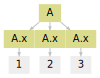

In [17]:
A = fact(
    'A',
    ['x']
)
RULE = true().interpretation(
    A.x
).repeatable().interpretation(
    A
)

parser = Parser(RULE)
match = next(parser.match('1 2 3'))
match.tree.normalized.as_dot

В `A.x` попадёт 3:

In [18]:
match.fact

A(x=3)

Но бывает нужно сохранить содержание всех повторяющихся вершин-атрибутов, не только самой правой. В этом случае поле помечается как `repeatable`:

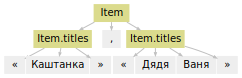

In [19]:
from yargy import not_


Item = fact(
    'Item',
    [attribute('titles').repeatable()]
)

TITLE = rule(
    '«',
    not_(eq('»')).repeatable(),
    '»'
)
ITEM = rule(
    TITLE.interpretation(
        Item.titles
    ),
    eq(',').optional()
).repeatable().interpretation(
    Item
)

parser = Parser(ITEM)
text = '«Каштанка», «Дядя Ваня»'
match = next(parser.match(text))
match.tree.normalized.as_dot

«Дядя Ваня» не перезапишет «Каштанка», они оба окажутся в `Item.titles`:

In [20]:
match.fact

Item(titles=['«Каштанка»', '«Дядя Ваня»'])

Остался последний неочевидный случай, когда ребёнок вершины-конструктора, другая вершина-конструктор. Такая ситуация возникает при использовании рекурсивных грамматик:

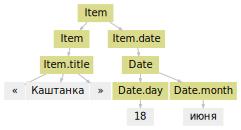

In [21]:
from yargy import forward, or_

Item = fact(
    'Item',
    ['title', 'date']
)

ITEM = forward().interpretation(
    Item
)
ITEM.define(or_(
    TITLE.interpretation(
        Item.title
    ),
    rule(ITEM, TITLE),
    rule(
        ITEM,
        DATE.interpretation(
            Item.date
        )
    )
))

parser = Parser(ITEM)
text = '«Каштанка» 18 июня'
match = next(parser.match(text))
match.tree.normalized.as_dot

В ходе интерпретации появится два объекта: `Item(title='«Каштанка»', date=None)` и `Item(title=None, date=Date(18, 'июня'))`. В конце произойдёт слияние:

In [22]:
match.fact

Item(title='«Каштанка»',
     date=Date(year=2017,
               month='июня',
               day=18))

## Нормализация

ТОДО про normalized , про raw, про то, что не только для атрибутов можно указывать, что если несколько токенов под атрибутом, про аргументы в inflected

## Согласование 

ТОДО список case_relation, number_relation .. несколько согласований в одной грамматике , согласование не только токенов